# Pre-Processing & Training

In [45]:
import numpy as np 
import pandas as pd 
import os

df=pd.read_csv('train.csv')
df_train=df.copy()
df_test=pd.read_csv('test.csv')
for field in ['Listed On', 'Last Sold On']:
    df_train[field]=pd.to_datetime(df[field])
    df_test[field]=pd.to_datetime(df_test[field])

#Preparing data
cate_cols = list(df_train.select_dtypes(include='object').columns)
date_cols = list(df_train.select_dtypes(include=['datetime', 'datetime64']).columns)
num_cols = list(set(df_train.columns) - set(cate_cols) - set(date_cols))
id_col = 'Id'
target_col = 'Sold Price'

num_cols = [col for col in num_cols if col not in [id_col, target_col]]

In [46]:
#pre-processing numerical data  (credit: kaggle submissions)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer

class Num_Features(BaseEstimator, TransformerMixin):
    def __init__(self, cols = [], fillna = False, addna = False):
        self.cols = cols
        self.fillna = fillna
        self.addna = addna
    
    def fit(self, X, y=None):
        self.imputers = {}
        self.na_cols = []
        
        for col in self.cols:
            if self.fillna:
                self.imputers[col] = X[col].median()
            if self.addna and X[col].isnull().sum():
                self.na_cols.append(col)  
        return self
    def transform(self, X, y=None):
        df = X[self.cols].copy()  
        for col in self.imputers:
            df[col].fillna(self.imputers[col], inplace=True)  
        for col in self.na_cols:
            df[col+'_na'] = X[col].isnull().astype(int)  
        return df
    
class Imputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy, fill_value):
        self.strategy = strategy
        self.fill_value = fill_value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col, content in X.items():
            X[col].fillna(self.fill_value, inplace=True)
        return X

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
num_pipeline = Pipeline([
    ('select_num', Num_Features(cols=num_cols, fillna='median', addna=True)),
])
X_num = num_pipeline.fit_transform(df_train)
cat_pipeline = Pipeline([
    ('cat_encoder', CatEncoder(cols=cate_cols))
])
X_cate = cat_pipeline.fit_transform(df_train)

[]


In [48]:
#categorical data encoder for pre-processing (credit: kaggle submissions)
class CatEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,cols, max_n_cat=7, onehot_cols=[], orders={}):
        self.cols = cols
        self.onehot_cols=onehot_cols
        self.cats = {}
        self.max_n_cat = max_n_cat
        self.orders = orders
    def fit(self, X, y=None):
        df_cat =  X.loc[:, self.cols]
        for n,c in df_cat.items():
            df_cat[n].fillna('NAN', inplace=True)
            df_cat[n] = c.astype('category').cat.as_ordered()
            if n in self.orders:
                df_cat[n].cat.set_categories(self.orders[n], ordered=True, inplace=True)
            cats_count = len(df_cat[n].cat.categories)
            if cats_count<=2 or cats_count>self.max_n_cat:
                self.cats[n] = df_cat[n].cat.categories
                if n in self.onehot_cols:
                    self.onehot_cols.remove(n)
            elif n not in self.onehot_cols:
                self.onehot_cols.append(n)

        print(self.onehot_cols)
        return self
    def transform(self, df, y=None):
        X = df.loc[:, self.cols]
        for col in self.cats:
            X[col].fillna('NAN', inplace=True)
            X.loc[:,col] = pd.Categorical(X[col], categories=self.cats[col], ordered=True)
            X.loc[:,col] = X[col].cat.codes
        if len(self.onehot_cols):
            df_1h = pd.get_dummies(X[self.onehot_cols], dummy_na=True)
            df_drop=X.drop(self.onehot_cols,axis=1)
            return pd.concat([df_drop, df_1h], axis=1)

        return X

In [49]:
# extracting date from dataset for future use.
def add_datepart(df, field_name, prefix=None, drop=True, time=False):
    field = df[field_name]
    if prefix is None:
        prefix = re.sub('[Dd]ate$', '', field_name)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    week = field.dt.isocalendar().week.astype(field.dt.day.dtype) if hasattr(field.dt, 'isocalendar') else field.dt.week
    for n in attr: df[prefix + n] = getattr(field.dt, n.lower()) if n != 'Week' else week
    mask = ~field.isna()
    df[prefix + 'Elapsed'] = np.where(mask,field.values.astype(np.int64) // 10 ** 9,np.nan)
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df
# appending date
import re
class Datepart(BaseEstimator, TransformerMixin):
    def __init__(self, cols, time=False):
        self.cols = cols
        self.time = time
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        df_dates = X.loc[:, self.cols]
        for col in self.cols:
            add_datepart(df_dates, col, time=False)
        return df_dates
    
date_pipeline = Pipeline([
    ('datepart', Datepart(cols=date_cols)),
    ('imputer', Imputer(strategy="constant", fill_value=-1)),
])

In [50]:
from sklearn.ensemble import RandomForestRegressor

X_date = date_pipeline.fit_transform(df_train)
y_train = np.log(df_train[target_col])
X_train = pd.concat([X_num, X_cate,X_date], axis=1)
X_train.shape, y_train.shape

m = RandomForestRegressor(n_jobs=-1, n_estimators=200, oob_score=True, max_depth=17, min_samples_leaf=4, min_samples_split=2, max_features=0.5)
m.fit(X_train, y_train)
m.oob_score_

0.9413697030734538

# PREDICTING

In [38]:
to_keep_final=['Listed Price', 'Tax assessed value', 'Last Sold Price', 'Zip', 'Total interior livable area', 'Elementary School Score', 'Listed OnElapsed', 'Last Sold OnElapsed','Full bathrooms', 'Year built', 'Listed OnYear', 'Lot', 'Parking','Type', 'Middle School Score', 'High School Distance', 'Elementary School Distance', 'Bedrooms']
X_train_final = X_train[to_keep_final].copy()

In [39]:
model_final = RandomForestRegressor(n_jobs=-1, n_estimators=550, max_depth=17, min_samples_leaf=4, min_samples_split=2, max_features=0.45)
model_final.fit(X_train_final, y_train)

RandomForestRegressor(max_depth=17, max_features=0.45, min_samples_leaf=4,
                      n_estimators=550, n_jobs=-1)

Best hyperparameters were chosen based off an external source.

In [40]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

X_test_num = num_pipeline.transform(df_test)
X_test_cate = cat_pipeline.transform(df_test)
X_test_date = date_pipeline.transform(df_test)
df_t = pd.concat([X_test_num, X_test_cate, X_test_date], axis=1)
df_t = df_t[to_keep_final]

In [41]:
pred=model_final.predict(df_t)
df_pred=pd.DataFrame({'Id':df_test['Id'],'Sold Price': np.exp(pred)})
print(df_pred.head())
df_pred.to_csv('predictions.csv', index=False)

      Id    Sold Price
0  47439  8.030299e+05
1  47440  5.016371e+05
2  47441  8.430470e+05
3  47442  8.002028e+05
4  47443  1.104185e+06


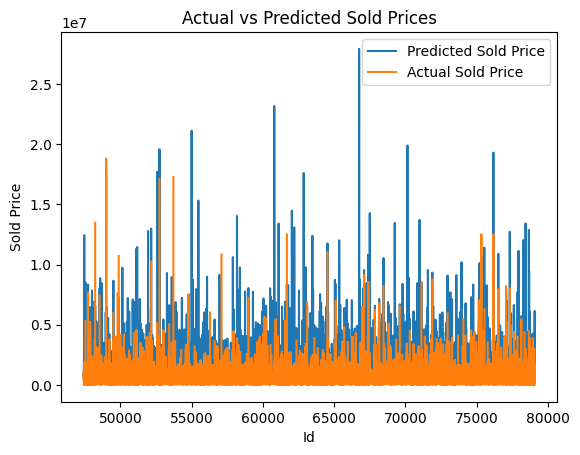

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

submission_df = pd.read_csv('predictions.csv')
test_df = pd.read_csv('test.csv')
merged_df = pd.merge(test_df, submission_df, on='Id')
merged_df.sort_values(by='Id', inplace=True)

plt.plot(merged_df['Id'], merged_df['Sold Price'], label='Predicted Sold Price')
plt.plot(merged_df['Id'], merged_df['Last Sold Price'], label='Actual Sold Price')
plt.title('Actual vs Predicted Sold Prices')
plt.xlabel('Id')
plt.ylabel('Sold Price')
plt.legend()
plt.show()

Graph of Actual vs Predicted Prices

In [43]:
import pandas as pd
df = pd.read_csv('predictions.csv')

# Reduce the values in the Sold Price column by 25%
df['Sold Price'] = df['Sold Price'] * 0.75

df.to_csv('ReducedPredictions.csv', index=False)

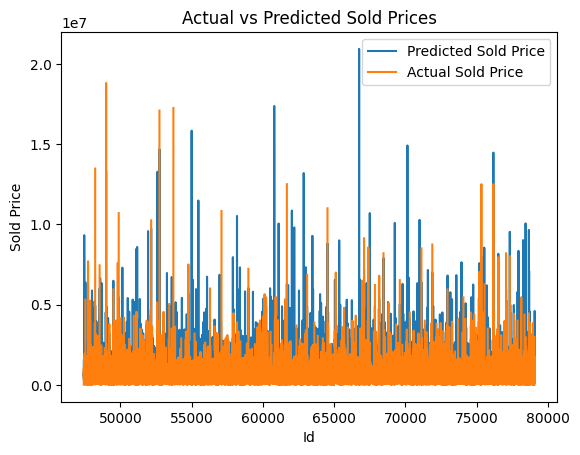

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

submission_df = pd.read_csv('ReducedPredictions.csv')
test_df = pd.read_csv('test.csv')
merged_df = pd.merge(test_df, submission_df, on='Id')
merged_df.sort_values(by='Id', inplace=True)

plt.plot(merged_df['Id'], merged_df['Sold Price'], label='Predicted Sold Price')
plt.plot(merged_df['Id'], merged_df['Last Sold Price'], label='Actual Sold Price')
plt.title('Actual vs Predicted Sold Prices')
plt.xlabel('Id')
plt.ylabel('Sold Price')
plt.legend()
plt.show()

Graph of Actual vs Predicted Prices with 25% redudction on predicted.